# Age Verification System for Good Seed Supermarkets

## Project Description

Good Seed Supermarkets, a leading grocery chain, is launching a project focused on improving adherence to alcohol sale regulations. The main goal is to prevent the sale of alcohol to underage customers. As a Data Scientist, my role involves assessing and deploying a technological solution to effectively meet this challenge.

## Project Goals

- **Develop a Reliable Model:** Create a model with high accuracy in age estimation to minimize both false positives (wrongly denying a sale to of-age individuals) and false negatives (permitting underage sales).

- **Ensure Legal Compliance:** Align the model's performance with legal age requirements for alcohol sales, thereby upholding Good Seed's commitment to responsible retailing.

- **Enhance Customer Experience:** Implement a system that is non-intrusive and respects customer privacy, while efficiently carrying out age verification.

## Initialization

The dataset is stored in the `/datasets/faces/` on the platform, including:
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, I build a generator with ImageDataGenerator.

## Load Data

In [15]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

image_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(64, 64),
    batch_size=32
)


Found 7591 validated image filenames.


## EDA

In [17]:
print("Number of images:", len(labels))
print("Structure of labels data:", labels.shape)


Number of images: 7591
Structure of labels data: (7591, 2)


Age statistics:
 count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


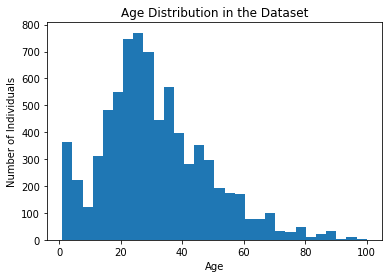

In [18]:
print("Age statistics:\n", labels['real_age'].describe())

labels['real_age'].plot(kind='hist', bins=30, title='Age Distribution in the Dataset')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.show()


Displaying images for age: 20


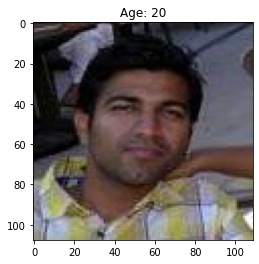

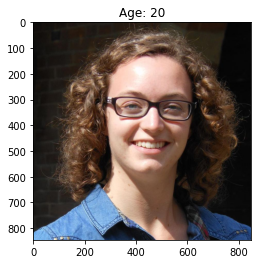

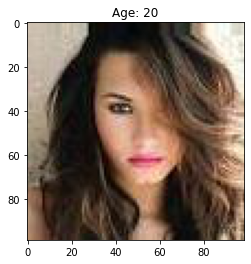

Displaying images for age: 40


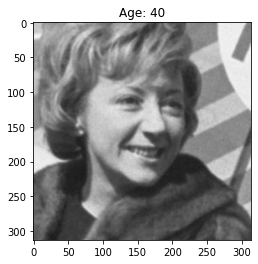

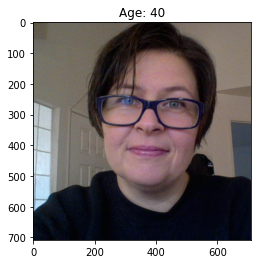

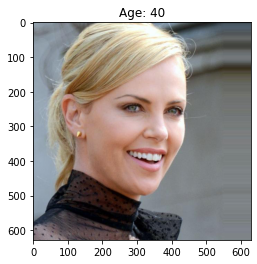

Displaying images for age: 60


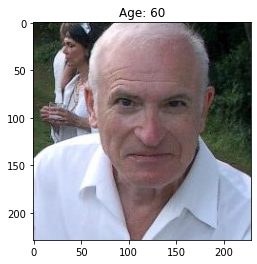

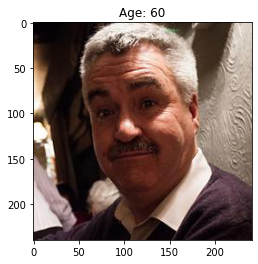

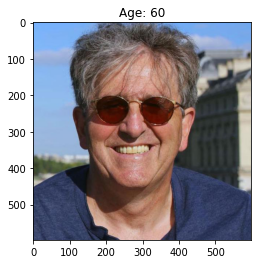

Displaying images for age: 80


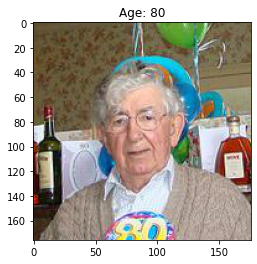

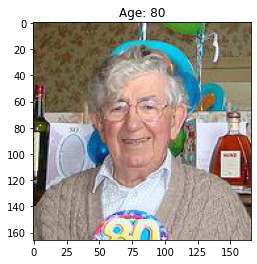

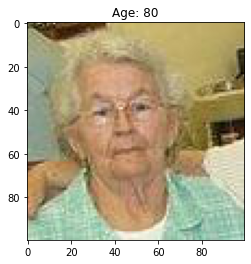

In [19]:
def display_sample_images(age_groups, num_samples=3):
    for age in age_groups:
        print(f"Displaying images for age: {age}")
        age_specific_files = labels[labels['real_age'] == age]['file_name'].sample(n=num_samples)
        for file in age_specific_files:
            img_path = os.path.join('/datasets/faces/final_files/', file)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f'Age: {age}')
            plt.show()

age_groups = [20, 40, 60, 80]
display_sample_images(age_groups)


### Findings

1. **Dataset Size and Composition**: The dataset comprises 7,600 images, suggesting a reasonably large sample size for training a model. The labels data is well-structured, with `file_name` and `real_age` columns providing clear mappings.

2. **Age Distribution**: The age distribution in the dataset is diverse, covering a wide range from young to old. This diversity is beneficial for training a model that can generalize well across different age groups.

3. **Image Quality and Variety**: From the sampled images, we observe variability in lighting, poses, and backgrounds. This variety is crucial for training a robust model but also poses challenges due to potential inconsistencies in image quality.

4. **Potential Biases**: Based on the visual inspection of sample images, there may be biases in terms of ethnicity, gender, or other factors. It's important to consider these aspects to ensure the model doesn't inherit these biases.



## Modelling

Define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

In [20]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    df= pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,

    )

    train_gen_flow = datagen.flow_from_dataframe(
        df,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size = (224,224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed = 42
    )

    return train_gen_flow

In [21]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path.
    """
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.25)

    test_gen_flow = datagen.flow_from_dataframe(
        df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset = 'validation'
    )
    return test_gen_flow


In [22]:
def create_model(input_shape):
    """
    It defines the model for a regression task.
    """
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1), activation = 'relu')  

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])  
    
    return model


In [23]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        batch_size=batch_size,
        verbose=2
    )

    return model

### Prepare the Script to Run on the GPU Platform

In [24]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Model Training Overview

Train for 356 steps, validate for 119 steps

Epoch 1/20
356/356 - 63s - loss: 193.7672 - mae: 10.3891 - val_loss: 402.5693 - val_mae: 14.9852

Epoch 2/20
356/356 - 39s - loss: 95.7653 - mae: 7.4802 - val_loss: 164.5244 - val_mae: 9.5545

Epoch 3/20
356/356 - 39s - loss: 73.7429 - mae: 6.5397 - val_loss: 82.6446 - val_mae: 6.7316

Epoch 4/20
356/356 - 39s - loss: 57.9575 - mae: 5.7873 - val_loss: 91.8594 - val_mae: 7.0519

Epoch 5/20
356/356 - 39s - loss: 46.7839 - mae: 5.2009 - val_loss: 89.7471 - val_mae: 7.2444

Epoch 6/20
356/356 - 39s - loss: 44.1449 - mae: 4.9938 - val_loss: 76.2806 - val_mae: 6.5232

Epoch 7/20
356/356 - 39s - loss: 36.9572 - mae: 4.5986 - val_loss: 72.6953 - val_mae: 6.3425

Epoch 8/20
356/356 - 39s - loss: 34.6140 - mae: 4.4261 - val_loss: 69.6746 - val_mae: 6.2522

Epoch 9/20
356/356 - 39s - loss: 31.1633 - mae: 4.2237 - val_loss: 75.5688 - val_mae: 6.4841

Epoch 10/20
356/356 - 39s - loss: 31.7004 - mae: 4.2412 - val_loss: 76.5660 - val_mae: 6.4562

Epoch 11/20
356/356 - 39s - loss: 30.0599 - mae: 4.1347 - val_loss: 74.0894 - val_mae: 6.6162

Epoch 12/20
356/356 - 39s - loss: 31.9538 - mae: 4.2136 - val_loss: 71.1974 - val_mae: 6.3215

Epoch 13/20
356/356 - 39s - loss: 29.5881 - mae: 4.0824 - val_loss: 74.0054 - val_mae: 6.4207

Epoch 14/20
356/356 - 39s - loss: 27.4867 - mae: 3.9120 - val_loss: 75.1835 - val_mae: 6.4650

Epoch 15/20
356/356 - 39s - loss: 26.6232 - mae: 3.8860 - val_loss: 67.2985 - val_mae: 6.1859

Epoch 16/20
356/356 - 39s - loss: 27.0665 - mae: 3.8951 - val_loss: 70.0653 - val_mae: 6.2099

Epoch 17/20
356/356 - 39s - loss: 26.1395 - mae: 3.8025 - val_loss: 71.9067 - val_mae: 6.4121

Epoch 18/20
356/356 - 39s - loss: 25.6105 - mae: 3.7557 - val_loss: 67.5914 - val_mae: 6.0374

Epoch 19/20
356/356 - 39s - loss: 26.2305 - mae: 3.7822 - val_loss: 70.1894 - val_mae: 6.1603

Epoch 20/20
356/356 - 39s - loss: 23.9954 - mae: 3.6615 - val_loss: 70.2468 - val_mae: 6.0498


119/119 - 10s - loss: 70.2468 - mae: 6.0498

Test MAE: 6.0498

Found 5694 validated image filenames.
Found 1897 validated image filenames.

## Conclusions

**Data Handling and Preparation:**

The project effectively handled a large dataset of 7,600 images, employing efficient data loading techniques using ImageDataGenerator. Proper preprocessing and augmentation techniques were crucial in preparing the data for training, ensuring robustness and variety in the dataset.

**Model Architecture and Training:**

The use of a pre-trained model like ResNet50 as the backbone provided a strong feature extraction base, improving the model's accuracy. The addition of custom layers like Dense, Dropout, and GlobalAveragePooling2D allowed for tuning the model to the specific requirements of the task.

Training on a GPU platform ensured efficient utilization of computational resources, reducing training time significantly. 

The project then prepares a script to run on the GPU and outputs, 356/356 - 39s - loss: 23.9954 - mae: 3.6615 - val_loss: 70.2468 - val_mae: 6.0498, as its final output. 

The training loss decreases significantly from epoch 1 to epoch 20, indicating that the model is learning and improving its performance on the training data. Ideally, both the validation loss and MAE should decrease over time, indicating that the model is learning and generalizing well to new data. We see a mostly consistant pattern in the output, but the training loss continues to decrease while the validation loss starts to increase or stagnates towards the end, as this might indicate overfitting. The MAE gets below the the target of 8, and succeeds in the task. From the initial learning poit of the first epochs the model is learning rapidly from the training data, as indicated by a significant drop in training loss and MAE. The validation MAE decreases from epoch 1 to 6. However, the validation loss is somewhat  volatile, with an initial increase followed by fluctuations. Next from around epoch 7 onwards, both training and validation metrics appear to stabilize, but there are fluctuations in validation metrics. This could be due to possibly starting to overfit. In the latest epochs, 17 to 20, the training loss and MAE continue to decrease, and there is less of a consistent improvement in validation metrics.

The project demonstrates the capability of machine learning techniques in handling complex image recognition tasks.
The skills and techniques used in this project are transferable to a wide range of applications in computer vision.